## E-2-E Model Optimizer

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import scipy.stats

In [ ]:
from google.colab import files
files.upload()

In [2]:
df = pd.read_csv('promotion_dataset.csv')
df.head(6)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,73,0
5,58896,Analytics,region_2,Bachelor's,m,sourcing,2,31,3.0,7,0,85,0


In [3]:
### Dropping employee ID 
df = df.drop('employee_id',1)
df.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,is_promoted
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,0,49,0
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,60,0
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,50,0
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,50,0
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,73,0


### Premilinary Data Analysis

In [57]:
X = df.loc[:,'department':'avg_training_score'] # employee_id is not considered for analysis
y = df[['is_promoted']]

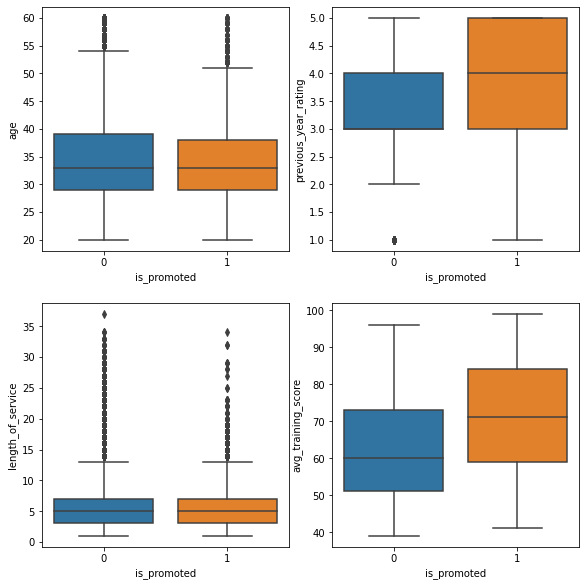

In [106]:
# plottinng boxplots for numeric variables
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(8,8))
index = 0
axs = axs.flatten()
for col in ['age','previous_year_rating','length_of_service','avg_training_score']:
    sns.boxplot(x=df['is_promoted'], y=df[col], ax = axs[index])
    index += 1
plt.tight_layout(pad=0.2, w_pad=0.2, h_pad=2.0)
plt.show()

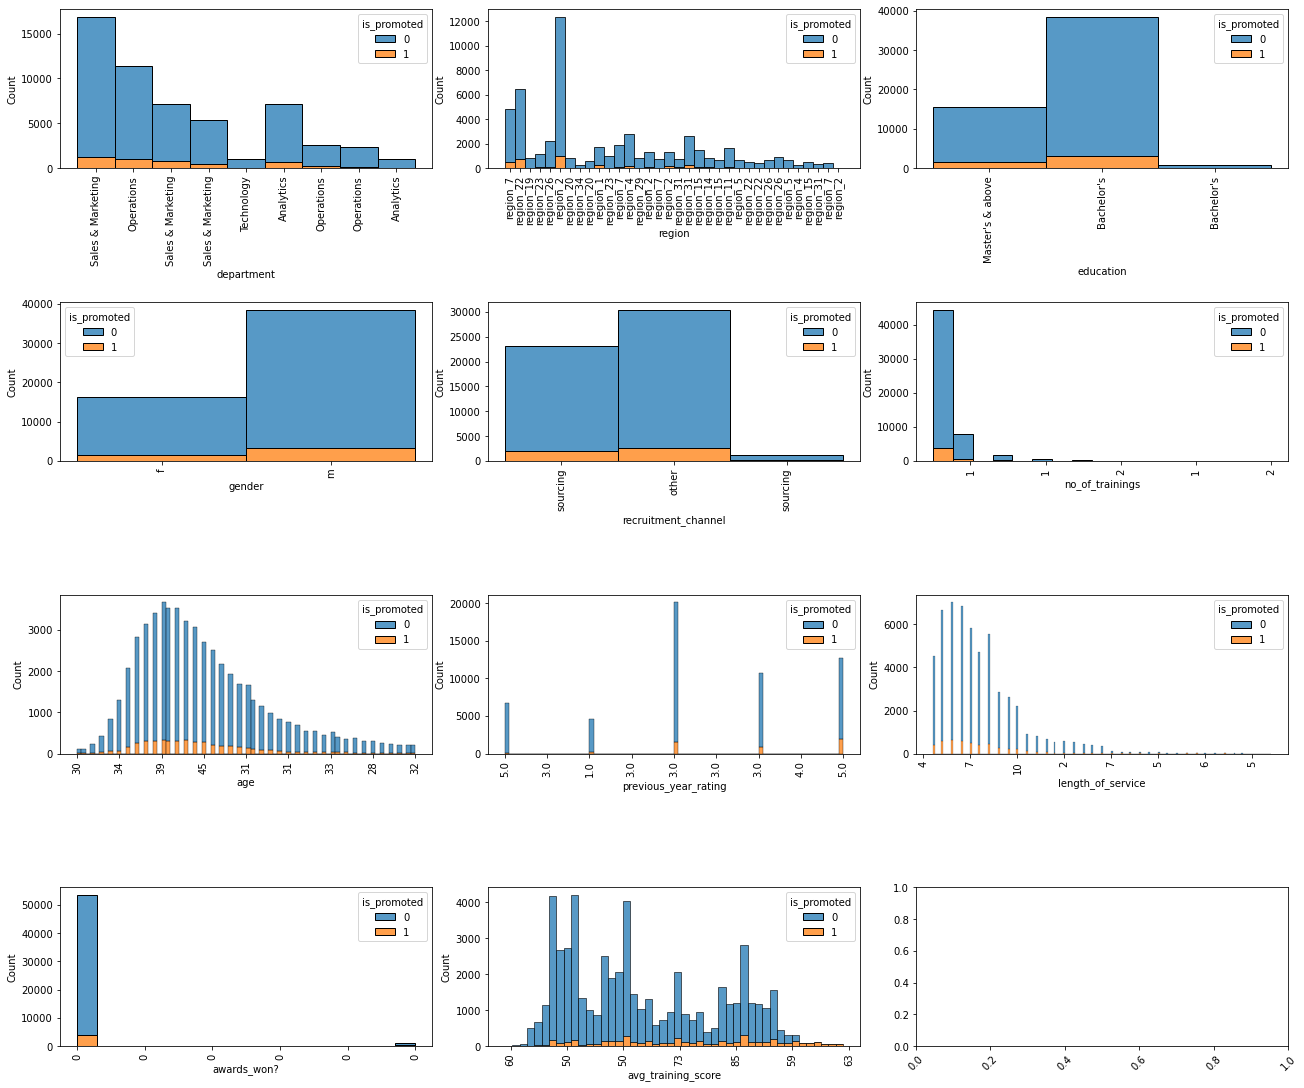

In [103]:
# histograms for each variables
fig2, axs2 = plt.subplots(ncols=3, nrows=4, figsize=(18, 15))
locs, labels = plt.xticks()
plt.setp(labels, rotation = 45)
index = 0
axs2 = axs2.flatten()
for cols in X:
    chart = sns.histplot(x = df[cols].fillna(axis = 0, method = 'ffill'), stat = 'count', multiple = 'stack',
                         ax=axs2[index], hue = df['is_promoted'], 
                         legend = True)
    chart.set_xticklabels(df[cols], rotation = 90)
    index += 1
plt.tight_layout(pad=0.3, w_pad=0.3, h_pad = 2.0)
plt.show()

#### Data Preprocessing

In [5]:
# creating a preprocessing pipeline

class Preprocess:
    
    def __init__(self, X):
        self.X = X
        
    # main preprocessing function
    def process(self):
        X = self.X
        # checking percentage of missing values
        percent_missing = (X.isnull().sum() * 100)/len(X)
        missing_value_df = pd.DataFrame({'column_name': X.columns,
                                 'percent_missing': percent_missing}).reset_index(drop = True)
        print('percentage of missing values per column:\n{}\n'.format(percent_missing))
        
        # Dropping columns with missing values more than 50%
        print('Dropping columns with percent missing > 50......')
        index_to_drop = []
        for i in range(len(missing_value_df)):
            if missing_value_df.at[i, 'percent_missing'] > 50:
                ind = missing_value_df.at[i, 'column_name']
                index_to_drop.append(ind)
    
        X_cleaned = X.drop(index_to_drop,axis = 1)
        
        #checking correlation and eliminating highly correlated columns
        # code adapted from : [https://stackoverflow.com/questions/29294983
        #/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on]
        print('checking correlation....')
        corr_matrix = X_cleaned.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
        to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
        if len(to_drop) > 0:
            print('Dropping columns:{}'.format(to_drop))
            X_cleaned = X_cleaned.drop(to_drop, axis=1, inplace=True)
        else:
            print('No significant correlation found')
        
        sns.heatmap(corr_matrix.abs(),  annot=True)
        plt.show()   
        
        X_final = Preprocess.impute(X_cleaned)
        return X_final
        
    # impute missing values
    def impute(X):
        # defining imputing strategy
        numeric_imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
        categorical_imputer = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
        
        # seperating numeric and categorical columns
        numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
        cat_cols = X.select_dtypes(include='object').columns.tolist()
        
        # imputing the missing values
        X_cat = X.loc[:,cat_cols]
        X_num = X.loc[:,numeric_cols]
        scalar = MinMaxScaler(feature_range=(0, 1))
        X_num = scalar.fit_transform(X_num)
        
        print('Imputing missing values.......')
        X_cat = pd.DataFrame(categorical_imputer.fit_transform(X_cat))
        X_num = pd.DataFrame(numeric_imputer.fit_transform(X_num))
        X_num.columns = numeric_cols
        X_cat.columns = cat_cols
        
        print('Encoding categorical variables....')
        X_cat_final = Preprocess.encode(X_cat)
        
        print('Building final dataframe......')
        X_final = pd.concat([X_num, X_cat_final], axis = 1)
        print('Final df prepared\n')
        return X_final
        
    # encoding categorical variables using OneHotEncoder
    def encode(X_cat):
        columns = X_cat.columns.tolist()
        OH_encoder = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
        encoded_df = OH_encoder.fit_transform(X_cat)
        column_name = OH_encoder.get_feature_names(columns)
        encoded_df = pd.DataFrame(encoded_df,columns = column_name)
        return encoded_df

### Evaluating classifiers

In [8]:
class modelEvaluator:
    
    def __init__(self,df):
        self.df = df
        n = len(df.columns)
        X_raw = df.iloc[:, :n-1]
        X = Preprocess(X_raw).process()
        y = pd.DataFrame(df.iloc[:,-1])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
    def trainRandomForest(self):
        # defining features and variable
        X_train = self.X_train
        y_train = self.y_train

        # defininng paramenters for Random Forest Classifier
        n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
        max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
        min_samples_split = [2, 5, 10]
        min_samples_leaf = [1, 2, 4]

        # random grid
        random_grid = {'n_estimators': n_estimators,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                      }
        model = RandomForestClassifier()
        model_optimized = RandomizedSearchCV(estimator = model, 
                                       param_distributions = random_grid, 
                                       n_iter = 10, cv = 3, verbose = 2, 
                                       n_jobs = -1)
        
        model_optimized.fit(X_train, y_train)
        param = model_optimized.best_params_
        model_final = RandomForestClassifier(**param)
        return model_final
        
    def trainSVM(self):
        X_train = self.X_train
        y_train = self.y_train
        
        random_grid = {'C': scipy.stats.expon(scale=100), 'gamma': scipy.stats.expon(scale=.1),
             'kernel': ['rbf'], 'class_weight':['balanced', None]}
        
        model = SVC()
        model_optimized = RandomizedSearchCV(estimator = model, 
                                       param_distributions = random_grid, 
                                       n_iter = 10, cv = 3, verbose = 2, 
                                       n_jobs = -1)
        
        model_optimized.fit(X_train, y_train)
        param = model_optimized.best_params_
        model_final = SVC(**param) 
        return model_final
    
    def evaluator(self):
        X_test = self.X_test
        y_test = self.y_test
        X_train = self.X_train
        y_train = self.y_train
        
        rfc = modelEvaluator.trainRandomForest(self)
        rfc.fit(X_train, y_train)
        y_rfc = rfc.predict(X_test)
        accuracy_rfc = accuracy_score(y_test, y_rfc)
        print('\nAccuracy of RandomForestClassifier is: {}'.format(accuracy_rfc))
        print('Best parameters are:\n{}\n'.format(rfc.get_params()))
        
        rfc_default = RandomForestClassifier()
        rfc_default.fit(X_train, y_train)
        y_rfc_default = rfc_default.predict(X_test)
        accuracy_rfc_default = accuracy_score(y_test, y_rfc_default)
        
        fpr_rfc, tpr_rfc, auc_rfc = modelEvaluator.calcROC(y_test, y_rfc)
        fpr_rfc_def, tpr_rfc_def, auc_rfc_def = modelEvaluator.calcROC(y_test, y_rfc_default)
        print('Receiver Operating Characteristic for Random Forest\n')
        modelEvaluator.plot_roc(fpr_rfc, tpr_rfc, auc_rfc, fpr_rfc_def, tpr_rfc_def, auc_rfc_def )
        
        svm = modelEvaluator.trainSVM(self)
        svm.fit(X_train, y_train)
        y_svm = svm.predict(X_test)
        accuracy_svm = accuracy_score(y_test, y_svm)
        print('\nAccuracy of SVM is is: {}'.format(accuracy_svm))
        print('Best parameters are:\n{}'.format(svm.get_params()))
        
        svm_default = SVC()
        svm_default.fit(X_train, y_train)
        y_svm_default = svm_default.predict(X_test)
        accuracy_svm_default = accuracy_score(y_test, y_svm_default)
        
        fpr_svm, tpr_svm, auc_svm = modelEvaluator.calcROC(y_test, y_svm)
        fpr_svm_def, tpr_svm_def, auc_svm_def = modelEvaluator.calcROC(y_test, y_svm_default)
        print('Receiver Operating Characteristic for SVM\n')
        modelEvaluator.plot_roc(fpr_svm, tpr_svm, auc_svm, fpr_svm_def, tpr_svm_def, auc_svm_def )
        
        if accuracy_rfc > accuracy_svm:
            print('\nBetter performing model is Random Forest Classifier\n')
            model = rfc
        
        else:
            print('\nBetter performing model is SVM\n')
            model = svm
        
        metrics = pd.DataFrame({'models' : ['Random Forest','Random Forest Baseline', 'SVM', 'SVM Baseline'],
                               'accuracy score' : [accuracy_rfc, accuracy_rfc_default, 
                                                   accuracy_svm, accuracy_svm_default],
                               'AUC' : [auc_rfc, auc_rfc_def, auc_svm, auc_svm_def]})
        print('\performance metrics :\n{}\n'.format(metrics.head()))
        return metrics, model
    
    def plot_roc(fpr,tpr,auc, fp_baseline, tp_baseline, auc_baseline):
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
        plt.plot(fp_baseline, tp_baseline,'g', label = 'Baseline AUC = %0.2f' % auc_baseline)
        plt.plot([0, 1], [0, 1],'r--')
        plt.legend(loc = 'lower right')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        
    def calcROC(y_test, pred):
        fpr, tpr, thresholds = roc_curve(y_test, pred)
        auc_roc = auc(fpr, tpr)
        
        return fpr, tpr, auc_roc

percentage of missing values per column:
department              0.000000
region                  0.000000
education               4.395344
gender                  0.000000
recruitment_channel     0.000000
no_of_trainings         0.000000
age                     0.000000
previous_year_rating    7.524449
length_of_service       0.000000
awards_won?             0.000000
avg_training_score      0.000000
dtype: float64

Dropping columns with percent missing > 50......
checking correlation....
No significant correlation found


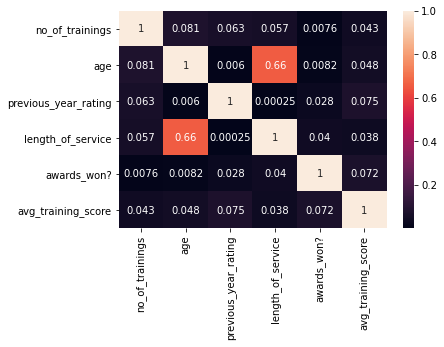

Imputing missing values.......
Encoding categorical variables....
Building final dataframe......
Final df prepared
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Accuracy of RandomForestClassifier is: 0.9361407093854912
Best parameters are:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 40, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

Receiver Operating Characteristic for Random Forest



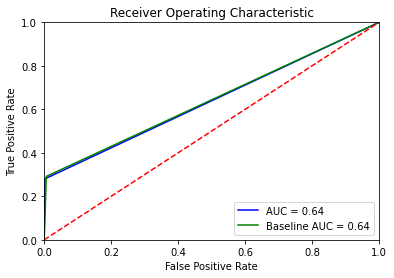

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Accuracy of SVM is is: 0.9307400379506642
Best parameters are:
{'C': 40.602818331379076, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.12312500617045903, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Receiver Operating Characteristic for SVM



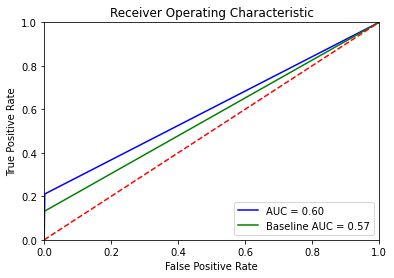


Better performing model is Random Forest Classifier

\performance metrics :
                   models  accuracy score       AUC
0           Random Forest        0.936141  0.639069
1  Random Forest Baseline        0.933440  0.642596
2                     SVM        0.930740  0.604554
3            SVM Baseline        0.925120  0.565301



In [100]:
performance, model = modelEvaluator(df).evaluator()

percentage of missing values per column:
department              0.000000
region                  0.000000
education               4.395344
gender                  0.000000
recruitment_channel     0.000000
no_of_trainings         0.000000
age                     0.000000
previous_year_rating    7.524449
length_of_service       0.000000
awards_won?             0.000000
avg_training_score      0.000000
dtype: float64

Dropping columns with percent missing > 50......
checking correlation....
No significant correlation found


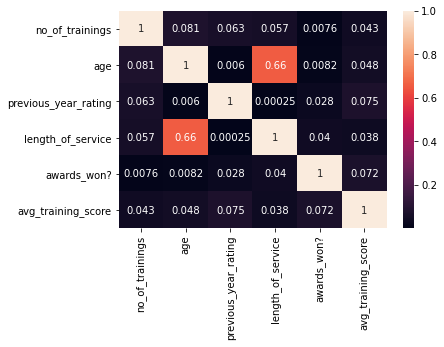

Imputing missing values.......
Encoding categorical variables....
Building final dataframe......
Final df prepared

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Accuracy of RandomForestClassifier is: 0.9376003503138228
Best parameters are:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 80, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 400, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

Receiver Operating Characteristic for Random Forest



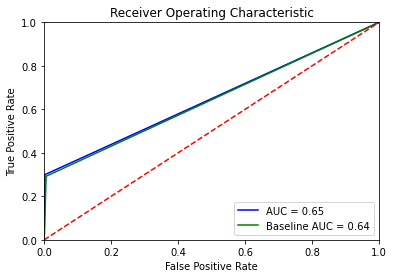

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Accuracy of SVM is is: 0.9364326375711575
Best parameters are:
{'C': 214.87327585289617, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.11894592273257282, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Receiver Operating Characteristic for SVM



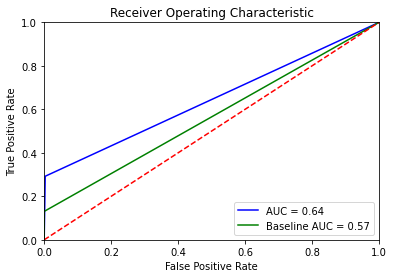


Better performing model is Random Forest Classifier

\performance metrics :
                   models  accuracy score       AUC
0           Random Forest        0.937600  0.648720
1  Random Forest Baseline        0.933951  0.643260
2                     SVM        0.936433  0.644617
3            SVM Baseline        0.925120  0.565301



In [9]:
trial2_performance, model2 = modelEvaluator(df).evaluator()